In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
from joblib import parallel_backend

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    print_report,
    show_feature_importance,
    transform_and_scale_df,
    get_worst_params_df,
)
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH

In [36]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [37]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [38]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

In [39]:
class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6719252445731612
	0-1: 0.6972429817947734
	1/2-1/2: 12.900070154830079


In [40]:
x_train_data, y_train = get_x_and_y(train_data, predict_draws=True)
x_valid_data, y_valid = get_x_and_y(valid_data, predict_draws=True)

## Random Forest

In [41]:
random_forest_params = {
    "n_estimators": [24, 32, 56],
    "max_depth": [10, 11, 12],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [7e-5, 13e-5, 25e-5, 50e-5],
    "min_samples_leaf": [1e-5, 3e-5, 8e-5, 12e-5],
    "min_impurity_decrease": [5e-6, 1e-5, 1e-4, 2e-4],
    "min_weight_fraction_leaf": [0.0, 1e-5, 2e-5, 5e-5],
    "max_leaf_nodes": [None, 350, 400, 450],
}

forest_clf = RandomForestClassifier(
    class_weight=class_weights, verbose=0, n_jobs=-1, random_state=BASELINE_RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=random_forest_params,
    n_iter=15,
    cv=5,
    verbose=3,
    random_state=BASELINE_RANDOM_STATE,
    scoring="recall_macro",
    return_train_score=True,
)

In [42]:
_ = random_search.fit(x_train_data, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.473, test=0.465) total time=   8.8s
[CV 2/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.475, test=0.468) total time=   8.1s
[CV 3/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.472, test=0.471) total time=   7.9s
[CV 4/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=

In [43]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.4706544388340549
Best Parameters: {'n_estimators': 56, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.00013, 'min_samples_leaf': 1e-05, 'min_impurity_decrease': 5e-06, 'max_leaf_nodes': 450, 'max_features': 0.5, 'max_depth': 10}


Let's take a look at the worst parameters.

In [44]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_n_estimators param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_leaf_nodes param_max_features param_max_depth                 
24                 0.00002                        0.00013                 0.00003                0.0002                      400                  sqrt               11                      0.462215
56                 0.00005                        0.00013                 0.00001                0.0002                      400                  sqrt               12                      0.463255
32                 0.00005                        0.00007                 0.00001                0.0002                      350                  0.5                10                      0.465558
56                 0.00000                        0.00007                 0.00012                0.0002                      350                  0.5                12                      0.466173
                   0.00005                        0.00025                 0.00001                0.0002                      400                  0.5                11                      0.466176

In [45]:
best_forest_clf = random_search.best_estimator_.fit(x_train_data, y_train)

In [46]:
print_report(best_forest_clf, x_train_data, y_train, x_valid_data, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.60      0.45      0.51    378005              0.59      0.44      0.51     45215
         1-0       0.62      0.43      0.51    392248              0.62      0.43      0.51     47511
     1/2-1/2       0.05      0.59      0.09     20431              0.05      0.54      0.09      2537
    accuracy                           0.44    790684                                  0.44     95263
   macro avg       0.42      0.49      0.37    790684              0.42      0.47      0.37     95263
weighted avg       0.60      0.44      0.50    790684              0.59      0.44      0.50     95263
       


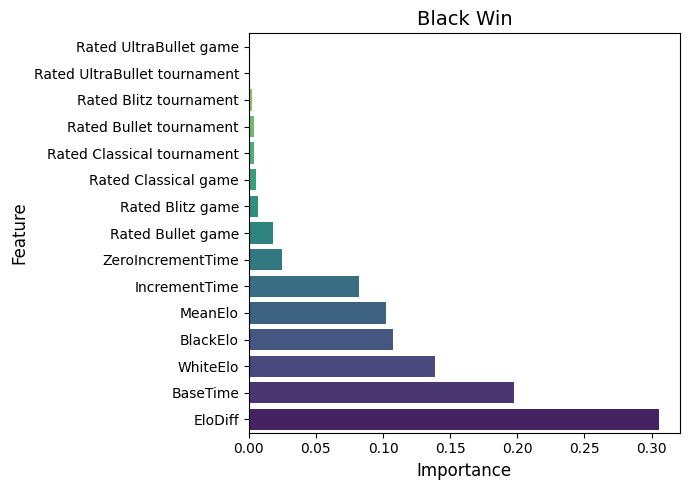

In [47]:
feature_importance = best_forest_clf.feature_importances_.reshape(1, -1)
show_feature_importance(best_forest_clf, feature_importance)

## Gradient Boosting

In [17]:
gradient_boosting_params = {
    "n_estimators": [10],
    "max_depth": [2, 4, 6],
    "max_features": ["sqrt"],
    "learning_rate": [0.1, 0.01],
    "tol": [1e-2],
    "min_samples_split": [1e-3, 1e-4, 1e-5, 1e-6],
    "min_samples_leaf": [1e-3, 1e-4, 1e-5, 1e-6],
    "min_impurity_decrease": [0.0, 1e-3, 1e-4, 1e-5, 1e-6],
    "min_weight_fraction_leaf": [0.0, 1e-3, 1e-4, 1e-5, 1e-6],
}

boosting_clf = GradientBoostingClassifier(verbose=0, validation_fraction=0.1)

random_search = RandomizedSearchCV(
    estimator=boosting_clf,
    param_distributions=gradient_boosting_params,
    n_iter=8,
    cv=3,
    verbose=3,
    random_state=42,
    scoring="recall_macro",
    return_train_score=True,
    # pre_dispatch=7,
    n_jobs=-1,
)

In [24]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

with parallel_backend("multiprocessing"):
    random_search.fit(x_train_data, y_train, sample_weight=sample_weights)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 2/3] END learning_rate=0.01, max_depth=4, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1e-06, min_samples_split=0.001, min_weight_fraction_leaf=0.0001, n_estimators=2, tol=0.1;, score=(train=0.454, test=0.455) total time=   8.9s
[CV 1/3] END learning_rate=0.01, max_depth=4, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1e-06, min_samples_split=0.001, min_weight_fraction_leaf=0.0001, n_estimators=2, tol=0.1;, score=(train=0.455, test=0.453) total time=   9.5s
[CV 3/3] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_impurity_decrease=1e-05, min_samples_leaf=1e-05, min_samples_split=0.0001, min_weight_fraction_leaf=0.001, n_estimators=8, tol=0.1;, score=(train=0.455, test=0.453) total time=  14.0s[CV 2/3] END learning_rate=0.1, max_depth=2, max_features=sqrt, min_impurity_decrease=1e-05, min_samples_leaf=1e-05, min_samples_split=0.0001, min_weight_fraction_leaf=0.001, n_estima

In [25]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.4671428908253918
Best Parameters: {'tol': 0.1, 'n_estimators': 8, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 1e-05, 'min_samples_leaf': 1e-06, 'min_impurity_decrease': 0.0001, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.1}


In [26]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_tol param_n_estimators param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_features param_max_depth param_learning_rate                 
0.1       4                  0.0001                         0.000001                0.000010               0.00000                     sqrt               2               0.01                        0.444870
          2                  0.0001                         0.001000                0.000001               0.00100                     sqrt               4               0.01                        0.448312
          8                  0.0010                         0.000100                0.000010               0.00001                     sqrt               2               0.10                        0.452212
          4                  0.0000                         0.000010                0.000010               0.00100                     sqrt               4               0.01                        0.456735
                             0.0010                         0.000010                0.000001               0.00001                     sqrt               4               0.01                        0.457978

In [31]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

best_boosting_clf = random_search.best_estimator_.fit(x_train_data, y_train, sample_weight=sample_weights)

In [32]:
print_report(best_boosting_clf, x_train_data, y_train, x_valid_data, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.60      0.41      0.49    378005              0.60      0.41      0.48     45215
         1-0       0.61      0.43      0.50    392248              0.61      0.43      0.50     47511
     1/2-1/2       0.05      0.58      0.08     20431              0.05      0.56      0.08      2537
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.47      0.36    790684              0.42      0.46      0.36     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.48     95263
       


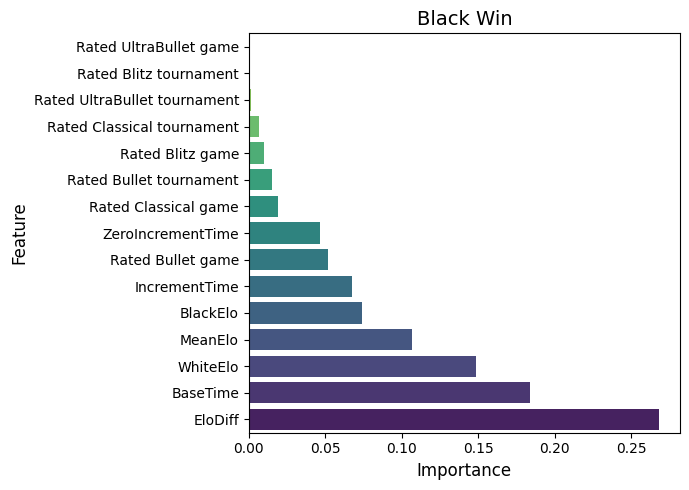

In [33]:
feature_importance = best_boosting_clf.feature_importances_.reshape(1, -1)
show_feature_importance(best_boosting_clf, feature_importance)